# Word2Vec

The code for this lecture is based off the great tutorial example from tensorflow!

Walkthrough:

https://www.tensorflow.org/tutorials/word2vec



# Step 0: Imports

In [1]:
import collections
import math
import os
import errno
import random
import zipfile
import requests
import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Step 1: The data.

In [2]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [3]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [4]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    print(zip_path)
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        download_url(url,zip_path)
#         urllib.request.urlretrieve(url, zip_path)
    
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [5]:
# Use Defaults (this make take awhile!!)
words = fetch_words_data()

word2vec_data/words\words.zip


In [6]:
with zipfile.ZipFile('word2vec_data/words\words.zip') as f:
    data = f.read(f.namelist()[0])
type(data)

bytes

In [7]:
data.decode("ascii")[:1000]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institut

In [8]:
len(data.decode("ascii"))

100000000

In [9]:
# Total words
len(words)

17005207

In [10]:
# Random slice of words
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [40]:
words[0]

'anarchism'

In [11]:
for w in words[9000:9040]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

## Build Word Counts

In [12]:
from collections import Counter

In [13]:
mylist = ["one",'one','two']

In [14]:
Counter(mylist)

Counter({'one': 2, 'two': 1})

In [15]:
Counter(mylist).most_common(1)

[('one', 2)]

## Create Word Data and Vocab

In [16]:
def create_counts(vocab_size=50000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [31]:
vocab_size = 50000

In [30]:
dictionary = {'s':1,'b':2}
dictionary.get('d',0)

0

In [32]:
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)

In [37]:
vocabulary.shape

(50000,)

In [45]:
vocabulary[0]

'the'

In [33]:
data.shape

(17005207,)

In [39]:
vocabulary[5233]

'anarchism'

In [34]:
data[0]

5233

In [35]:
data.min()

0

In [36]:
data.max()

49999

In [47]:
(words[0],data[0],vocabulary[data[0]])

('anarchism', 5233, 'anarchism')

In [40]:
vocabulary.shape

(50000,)

In [53]:
vocabulary[np.random.randint(0,50000)]

'ionospheric'

## Function for Batches

Direct from the word2vec file from TensorFlow Docs

In [54]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [55]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [58]:
batch

array([3080, 3080, 3080, 3080, 3080, 3080, 3080, 3080])

In [59]:
labels

array([[  11],
       [5233],
       [  11],
       [5233],
       [  11],
       [5233],
       [5233],
       [  11]])

## Constants

In [60]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2        

In [61]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window,
                                  valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [62]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [63]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [64]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [65]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size,
         embedding_size],
        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [66]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

### Optimizer

In [67]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [68]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),
                             axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings,
                       normalized_embeddings,
                       transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [69]:
# Add variable initializer.
init = tf.global_variables_initializer()

# Session

In [70]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [75]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 20001

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {
            train_inputs : batch_inputs,
            train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run(
            [trainer, loss],
            feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", 
                  step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  266.1997375488281
Average loss at step  1000 :  7992.611325859069
Average loss at step  2000 :  22924.11036994171
Average loss at step  3000 :  33176.695852539066
Average loss at step  4000 :  31295.27297046113
Average loss at step  5000 :  36945.82188812918
Average loss at step  6000 :  37007.8809777733
Average loss at step  7000 :  40198.12351147461
Average loss at step  8000 :  37809.008302784016
Average loss at step  9000 :  39661.33167120838
Average loss at step  10000 :  42141.23789242554
Average loss at step  11000 :  39589.076078944585
Average loss at step  12000 :  40979.65078865135
Average loss at step  13000 :  44515.34055225548
Average loss at step  14000 :  41490.13895895386
Average loss at step  15000 :  42467.1443993063
Average loss at step  16000 :  45363.93213098145
Average loss at step  17000 :  47062.88117657471
Average loss at step  18000 :  47542.28795694779
Average loss at step  19000 :  45544.53401496887
Average loss at step  20000 :  4

# Visualizing Results

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels),
    "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

## TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [78]:
type(final_embeddings)

numpy.ndarray

In [79]:
final_embeddings.shape

(50000, 150)

In [80]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [81]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [82]:
labels = [vocabulary[i] for i in range(plot_only)]

In [83]:
low_dim_embs.shape

(2000, 2)

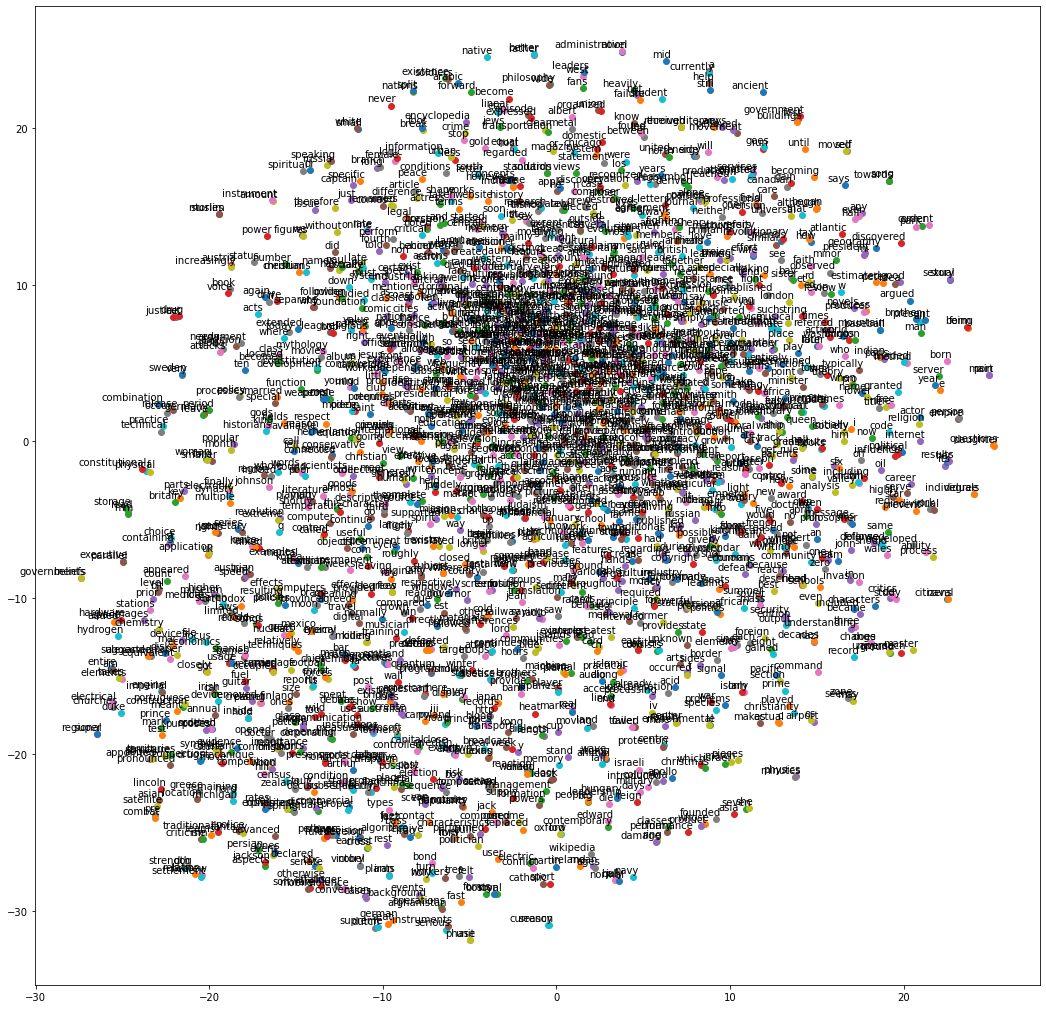

In [84]:
plot_with_labels(low_dim_embs, labels)

(-10.0, 10.0)

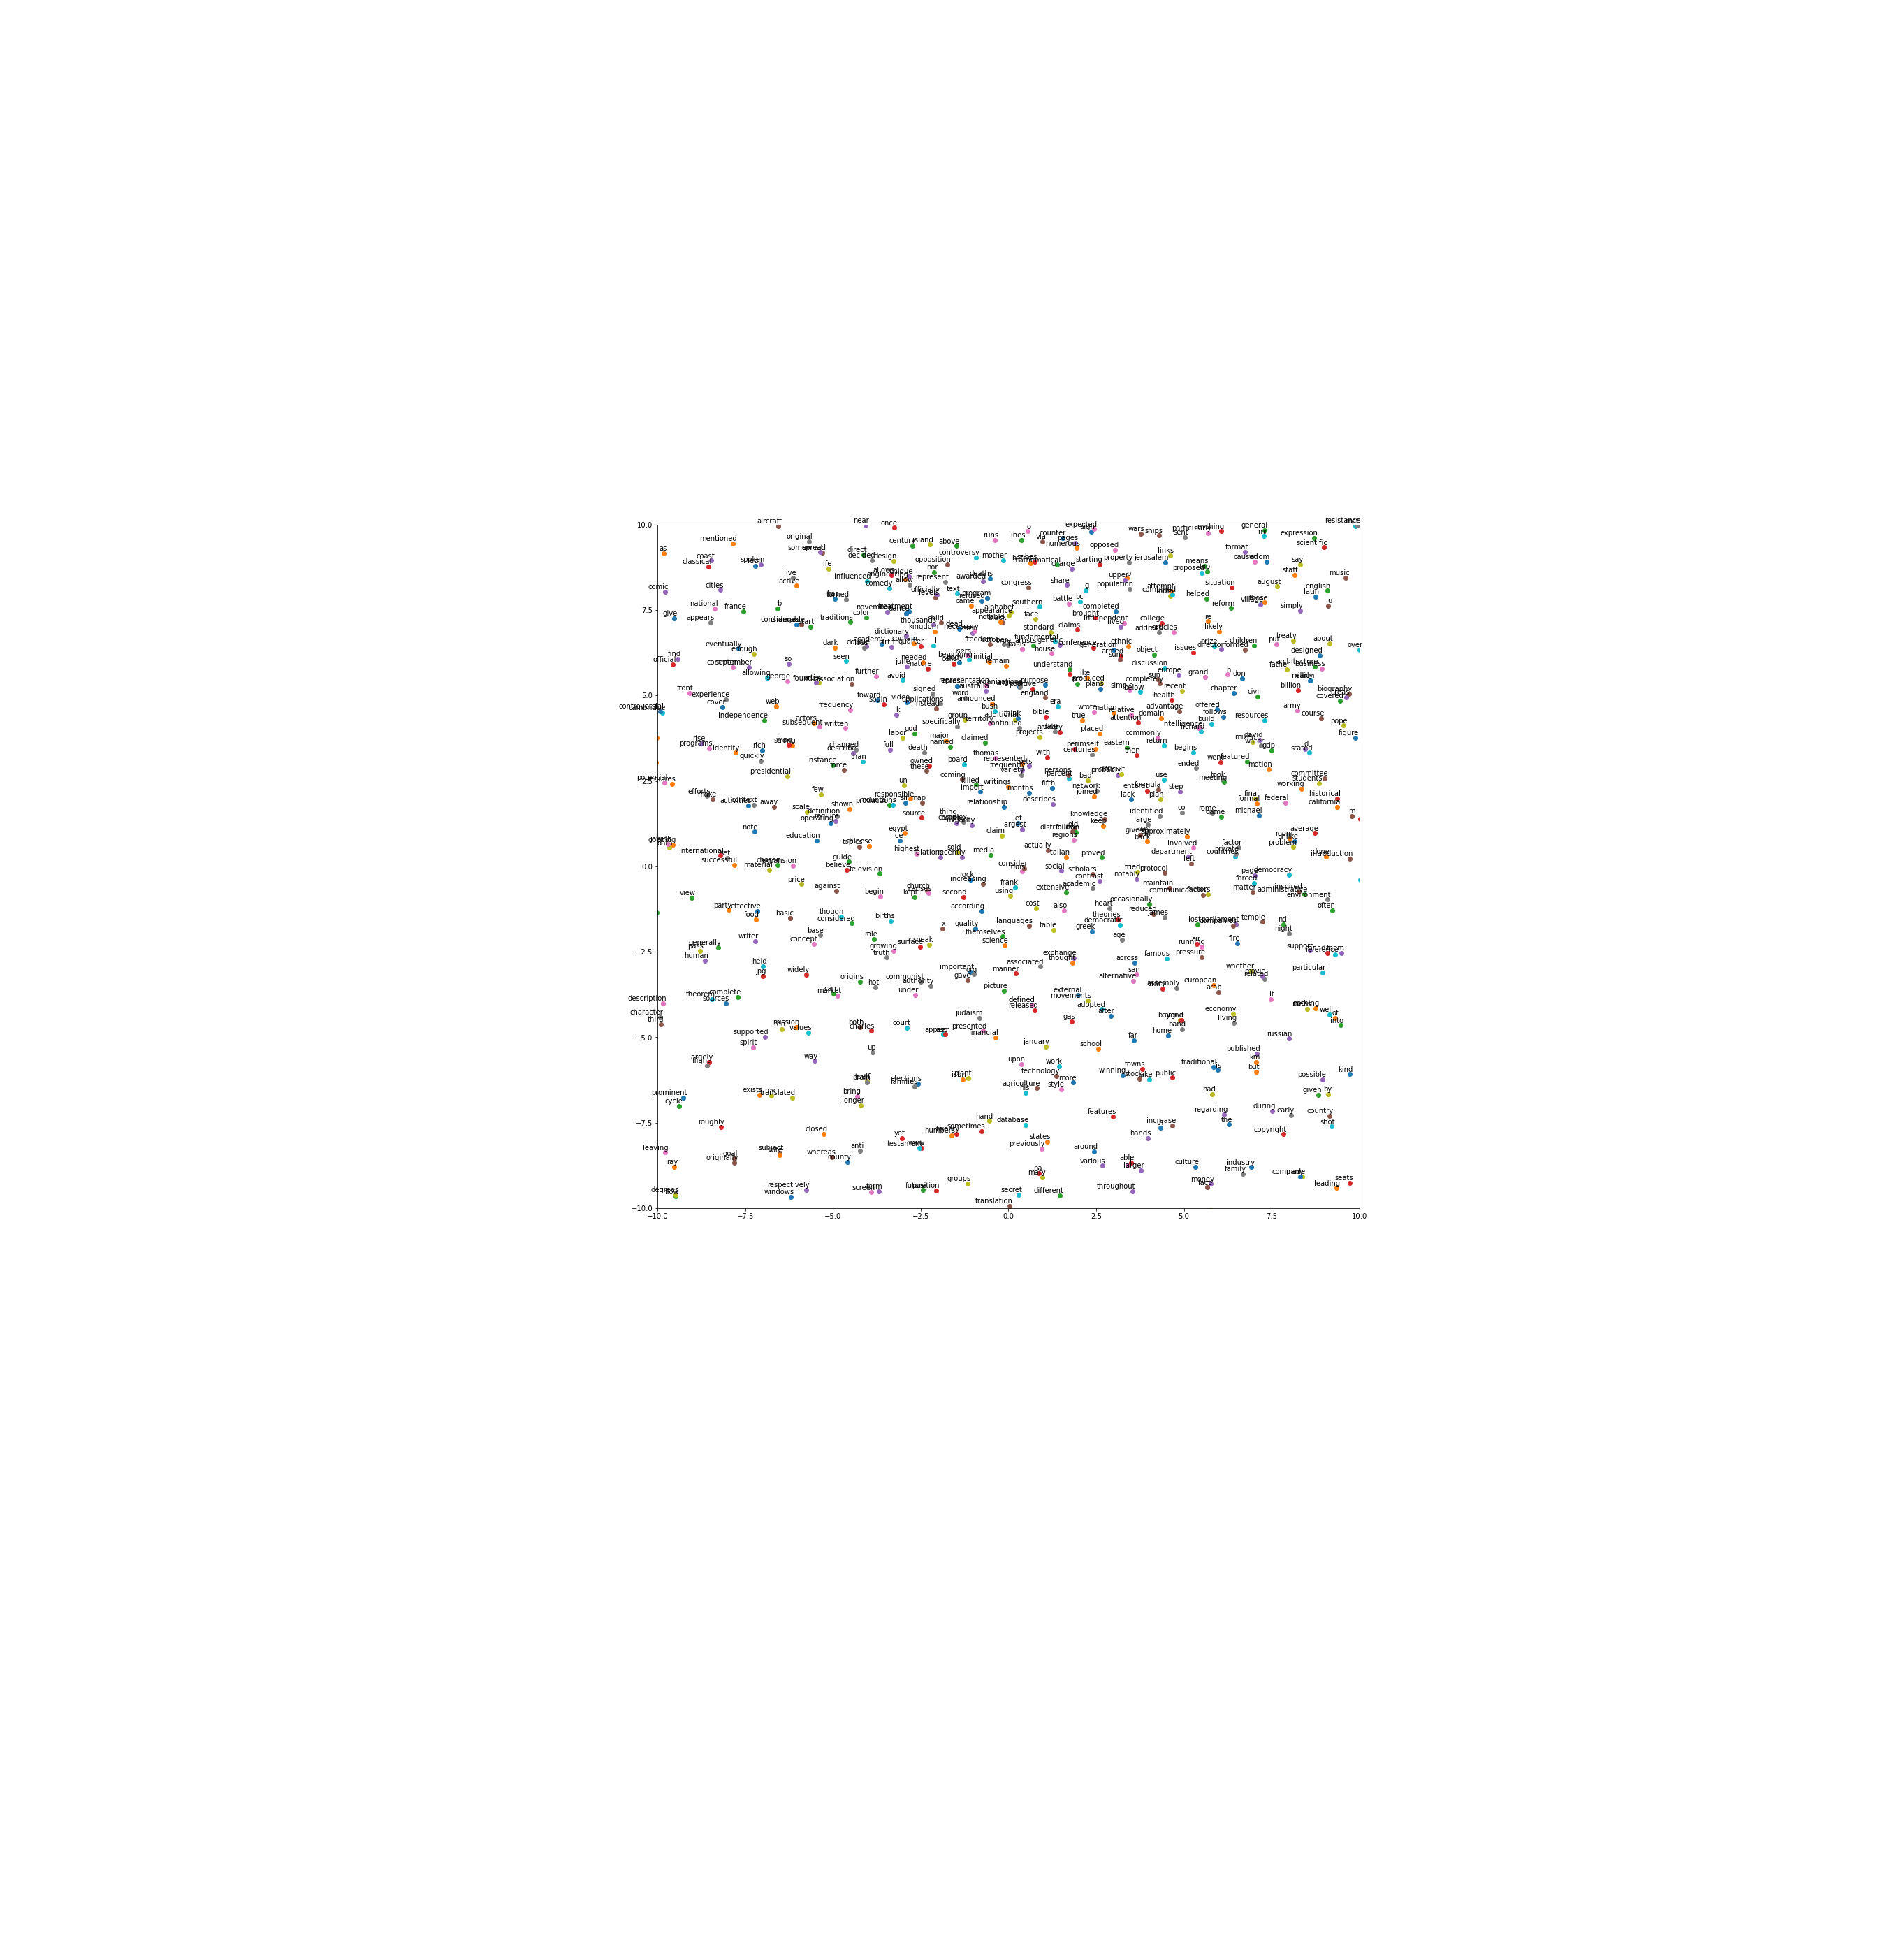

In [85]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

## Also check out gensim!

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [ ]:
np.save('trained_embeddings_200k_steps',final_embeddings)